# SQL

In [1]:
import pandas as pd
import sqlalchemy

from IPython.display import Image

# Movie Ratings

You've started a new movie-rating website, and you've been collecting data on reviewers' ratings of various movies. There's not much data yet, but you can still try out some interesting queries. Here's the schema: 

Movie ( mID, title, year, director ) 
English: There is a movie with ID number mID, a title, a release year, and a director. 

Reviewer ( rID, name ) 
English: The reviewer with ID number rID has a certain name. 

Rating ( rID, mID, stars, ratingDate ) 
English: The reviewer rID gave the movie mID a number of stars rating (1-5) on a certain ratingDate. 

## Connect to the database

In [2]:
engine = sqlalchemy.create_engine(
    "postgresql+psycopg2://",
    connect_args={
        "database": "postgres",
        "user": "faculty",
        "host": "/var/run/postgresql",
    },
)
con = engine.connect()
con.execute("SET schema 'input'")

## Load the data in the db
If you want to reset the database, simply rerun this cell

In [3]:
from sqlalchemy.sql import text

con.execute(open(".queries/movie-ratings.sql").read())
con.execute(open(".queries/social.sql").read())

In [4]:
q = """
SELECT 
    * 
FROM 
    Rating 
LIMIT 
    3
"""
df = pd.read_sql(q, con)
df

,rid,mid,stars,ratingdate
0,201,101,2,2011-01-22
1,201,101,4,2011-01-27
2,202,106,4,None


Find the titles of all movies directed by Steven Spielberg. 


In [5]:
q = """
SELECT 
    title
FROM 
    Movie
WHERE 
    director='Steven Spielberg';
"""
df = pd.read_sql(q, con)
df

,title
0,E.T.
1,Raiders of the Lost Ark


Find all years that have a movie that received a rating of 4 or 5, and sort them in increasing order. 

In [6]:
q = """
SELECT DISTINCT 
    year
FROM 
    Movie, Rating
WHERE 
    (Rating.mID = Movie.mID) AND (stars >= 4)
ORDER BY 
    Year;
"""
df = pd.read_sql(q, con)
df

,year
0,1937
1,1939
2,1981
3,2009


Find the titles of all movies that have no ratings. 


In [7]:
q = """
SELECT 
   title
FROM 
   Movie
WHERE 
   mID NOT IN (
       SELECT 
           mID 
       FROM 
           Rating
   )
"""
df = pd.read_sql(q, con)
df

,title
0,Star Wars
1,Titanic


Some reviewers didn't provide a date with their rating. Find the names of all reviewers who have ratings with a NULL value for the date. 


In [8]:
q = """
select distinct name
from Reviewer, Rating
where Reviewer.rID = Rating.rID and ratingDate is NULL;
"""
df = pd.read_sql(q, con)
df

,name
0,Daniel Lewis
1,Chris Jackson


Write a query to return the ratings data in a more readable format: reviewer name, movie title, stars, and ratingDate. Also, sort the data, first by reviewer name, then by movie title, and lastly by number of stars. 
 

In [9]:
q = """
select name, title, stars, ratingDate
from Movie, Rating, Reviewer
where Movie.mID = Rating.mID and Reviewer.rID = Rating.rID
order by name, title, stars;
"""
df = pd.read_sql(q, con)
df

,name,title,stars,ratingdate
0,Ashley White,E.T.,3,2011-01-02
1,Brittany Harris,Raiders of the Lost Ark,2,2011-01-30
2,Brittany Harris,Raiders of the Lost Ark,4,2011-01-12
3,Brittany Harris,The Sound of Music,2,2011-01-20
4,Chris Jackson,E.T.,2,2011-01-22
5,Chris Jackson,Raiders of the Lost Ark,4,None
6,Chris Jackson,The Sound of Music,3,2011-01-27
7,Daniel Lewis,Snow White,4,None
8,Elizabeth Thomas,Avatar,3,2011-01-15
9,Elizabeth Thomas,Snow White,5,2011-01-19


For all cases where the same reviewer rated the same movie twice and gave it a higher rating the second time, return the reviewer's name and the title of the movie. 

In [10]:
q = """
select name, title
from Movie, Reviewer, (select R1.rID, R1.mID
 from Rating R1, Rating R2
 where R1.rID = R2.rID 
 and R1.mID = R2.mID
 and R1.stars < R2.stars
 and R1.ratingDate < R2.ratingDate) C
where Movie.mID = C.mID
and Reviewer.rID = C.rID;
"""
df = pd.read_sql(q, con)
df

,name,title
0,Sarah Martinez,Gone with the Wind


For each movie that has at least one rating, find the highest number of stars that movie received. Return the movie title and number of stars. Sort by movie title. 

In [11]:
q = """
select title, stars
from Movie, ( select Movie.mID, stars
             from Movie, Rating
             where Movie.mID = Rating.mID
             except
             select R1.mID, R1.stars
             from Rating R1, Rating R2
             where R1.mID = R2.mID
             and R1.stars < R2.stars) Stars
where Movie.mID = Stars.mID
order by title;
"""
df = pd.read_sql(q, con)
df

,title,stars
0,Avatar,5
1,E.T.,3
2,Gone with the Wind,4
3,Raiders of the Lost Ark,4
4,Snow White,5
5,The Sound of Music,3


For each movie, return the title and the 'rating spread', that is, the difference between highest and lowest ratings given to that movie. Sort by rating spread from highest to lowest, then by movie title. 

In [12]:
q = """
select title, spread
from Movie, (
 select mID, max(stars) - min(stars) as spread
 from Rating
 group by mID
) RatingSpread
where Movie.mID = RatingSpread.mID
order by spread DESC, title;
"""
df = pd.read_sql(q, con)
df

,title,spread
0,Avatar,2
1,Gone with the Wind,2
2,Raiders of the Lost Ark,2
3,E.T.,1
4,Snow White,1
5,The Sound of Music,1


Find the difference between the average rating of movies released before 1980 and the average rating of movies released after 1980. (Make sure to calculate the average rating for each movie, then the average of those averages for movies before 1980 and movies after. Don't just calculate the overall average rating before and after 1980.) 

In [13]:
q = """
select avg(before_80.group_avg) - avg(post_80.group_avg) as difference
from (
 select Rating.mID, avg(stars) as group_avg
 from Rating, Movie
 where Rating.mID = Movie.mID
 and year <= 1980
 group by Rating.mID
) as before_80,
(
 select Rating.mID, avg(stars) as group_avg
 from Rating, Movie
 where Rating.mID = Movie.mID
 and year > 1980
 group by Rating.mID
) as post_80
"""
df = pd.read_sql(q, con)
df

,difference
0,0.055556


# The Social Network

Students at your hometown high school have decided to organize their social network using databases. So far, they have collected information about sixteen students in four grades, 9-12. Here's the schema: 

Highschooler ( ID, name, grade ) 
English: There is a high school student with unique ID and a given first name in a certain grade. 

Friend ( ID1, ID2 ) 
English: The student with ID1 is friends with the student with ID2. Friendship is mutual, so if (123, 456) is in the Friend table, so is (456, 123). 

Likes ( ID1, ID2 ) 
English: The student with ID1 likes the student with ID2. Liking someone is not necessarily mutual, so if (123, 456) is in the Likes table, there is no guarantee that (456, 123) is also present.

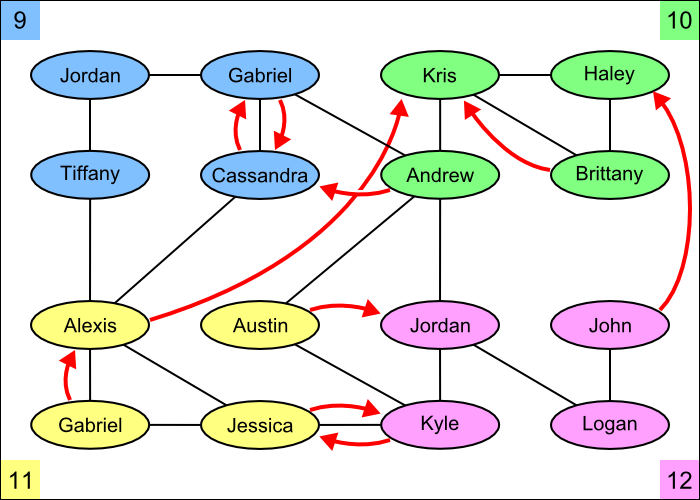

In [14]:
Image(filename=".img/social.png")

In [15]:
df = pd.read_sql("SELECT * from Highschooler limit 3", con)
df

,id,name,grade
0,1510,Jordan,9
1,1689,Gabriel,9
2,1381,Tiffany,9


Find the names of all students who are friends with someone named Gabriel. 


In [16]:
q = """
select H2.name
from Highschooler H1, Highschooler H2, Friend
where H1.ID = Friend.ID1
and H1.name = 'Gabriel'
and H2.ID = Friend.ID2;
"""
df = pd.read_sql(q, con)
df

,name
0,Jordan
1,Cassandra
2,Andrew
3,Alexis
4,Jessica


For every student who likes someone 2 or more grades younger than themselves, return that student's name and grade, and the name and grade of the student they like. 

In [17]:
q = """
select H1.name, H1.grade, H2.name, H2.grade
from Likes, Highschooler H1, Highschooler H2
where Likes.ID1 = H1.ID
and Likes.ID2 = H2.ID
and H1.grade >= (H2.grade + 2)
"""
df = pd.read_sql(q, con)
df

,name,grade,name,grade
0,John,12,Haley,10


For every pair of students who both like each other, return the name and grade of both students. Include each pair only once, with the two names in alphabetical order. 

In [18]:
q = """
select H1.name, H1.grade, H2.name, H2.grade
from Highschooler H1, Highschooler H2, (
 select L1.ID1, L1.ID2
 from Likes L1, Likes L2
 where L1.ID2 = L2.ID1
 and L1.ID1 = L2.ID2
) as Pair
where H1.ID = Pair.ID1
and H2.ID = Pair.ID2
and H1.name < H2.name
"""
df = pd.read_sql(q, con)
df

,name,grade,name,grade
0,Cassandra,9,Gabriel,9
1,Jessica,11,Kyle,12


Find all students who do not appear in the Likes table (as a student who likes or is liked) and return their names and grades. Sort by grade, then by name within each grade. 

In [19]:
q = """
select name, grade
from Highschooler
where ID not in (
 select ID1 from Likes
 union
 select ID2 from Likes
)
order by grade, name
"""
df = pd.read_sql(q, con)
df

,name,grade
0,Jordan,9
1,Tiffany,9
2,Logan,12


For every situation where student A likes student B, but we have no information about whom B likes (that is, B does not appear as an ID1 in the Likes table), return A and B's names and grades. 

In [20]:
q = """
select H1.name, H1.grade, H2.name, H2.grade, H3.name, H3.grade
from Likes L1, Likes L2, Highschooler H1, Highschooler H2, Highschooler H3
where L1.ID2 = L2.ID1
and L2.ID2 <> L1.ID1
and L1.ID1 = H1.ID and L1.ID2 = H2.ID and L2.ID2 = H3.ID
"""
df = pd.read_sql(q, con)
df

,name,grade,name,grade,name,grade
0,Gabriel,11,Alexis,11,Kris,10
1,Andrew,10,Cassandra,9,Gabriel,9


Find names and grades of students who only have friends in the same grade. Return the result sorted by grade, then by name within each grade. 

In [21]:
q = """
select name, grade
from Highschooler, (
 select ID1 from Friend
 except
 -- students have friends in same grade
 select distinct Friend.ID1
 from Friend, Highschooler H1, Highschooler H2
 where Friend.ID1 = H1.ID and Friend.ID2 = H2.ID
 and H1.grade != H2.grade
) as Sample
where Highschooler.ID = Sample.ID1
order by grade, name
"""
df = pd.read_sql(q, con)
df

,name,grade
0,Jordan,9
1,Brittany,10
2,Haley,10
3,Kris,10
4,Gabriel,11
5,John,12
6,Logan,12


For each student A who likes a student B where the two are not friends, find if they have a friend C in common (who can introduce them!). For all such trios, return the name and grade of A, B, and C. 

In [22]:
q = """
select H1.name, H1.grade, H2.name, H2.grade, H3.name, H3.grade
from Highschooler H1, Highschooler H2, Highschooler H3, Friend F1, Friend F2, (
 select * from Likes
 except
 -- A likes B and A/B are friends
 select Likes.ID1, Likes.ID2
 from Likes, Friend
 where Friend.ID1 = Likes.ID1 and Friend.ID2 = Likes.ID2
) as LikeNotFriend
where F1.ID1 = LikeNotFriend.ID1
and F2.ID1 = LikeNotFriend.ID2
-- has a shared friend
and F1.ID2 = F2.ID2
and H1.ID = LikeNotFriend.ID1
and H2.ID = LikeNotFriend.ID2
and H3.ID = F2.ID2
"""
df = pd.read_sql(q, con)
df

,name,grade,name,grade,name,grade
0,Austin,11,Jordan,12,Andrew,10
1,Austin,11,Jordan,12,Kyle,12
2,Andrew,10,Cassandra,9,Gabriel,9


Find the difference between the number of students in the school and the number of different first names. 


In [23]:
q = """
select count(ID) - count(distinct name) as difference
from Highschooler
"""
df = pd.read_sql(q, con)
df

,difference
0,2


Find the name and grade of all students who are liked by more than one other student. 


In [24]:
q = """
select name, grade
from Highschooler, (
  select count(ID1) as count, ID2
  from Likes
  group by ID2
) as LikeCount
where Highschooler.ID = LikeCount.ID2
and count > 1
"""
df = pd.read_sql(q, con)
df

,name,grade
0,Cassandra,9
1,Kris,10


## Modification

Add the reviewer Roger Ebert to your database, with an rID of 209. 


In [25]:
q = "insert into Reviewer(rID, name) values (209, 'Roger Ebert')"
con.execute(q)

Insert 5-star ratings by James Cameron for all movies in the database. Leave the review date as NULL. 


In [26]:
q = """
insert into Rating
  select Rating.rID, Movie.mID, 5 as stars, null as ratingDate
  from Rating, Movie, Reviewer
  where Rating.rID = Reviewer.rID
  and Reviewer.name = 'James Cameron';
"""
con.execute(q)

For all movies that have an average rating of 4 stars or higher, add 25 to the release year. (Update the existing tuples; don't insert new tuples.) 

In [27]:
q = """
update Movie
set year = year + 25
where mID in (
  select Movie.mId
  from Movie, Rating
  where Movie.mID = Rating.mID
  group by Movie.mID
  having avg(stars) >= 4
)
"""
con.execute(q)

Remove all ratings where the movie's year is before 1970 or after 2000, and the rating is fewer than 4 stars. 

In [28]:
q = """
delete from Rating
where mID in (
  select distinct Rating.mID
  from Movie, Rating
  where Movie.mID = Rating.mID
  and (Movie.year > 2000 or Movie.year < 1970)
)
and stars < 4
"""
con.execute(q)

It's time for the seniors to graduate. Remove all 12th graders from Highschooler. 


In [29]:
q = """
delete from Highschooler
where grade = 12
"""
con.execute(q)

If two students A and B are friends, and A likes B but not vice-versa, remove the Likes tuple. 


In [30]:
q = """
delete from Likes l
where l.ID1 in (
  select a.ID1 from (
    select L1.ID1, L1.ID2
    from Friend, Likes L1
    where Friend.ID1 = L1.ID1
    and Friend.ID2 = L1.ID2
    except
    select L1.ID1, L1.ID2
    from Likes L1, Likes L2
    where L1.ID1 = L2.ID2
    and L1.ID2 = L2.ID1
  ) a
)
"""
con.execute(q)

For all cases where A is friends with B, and B is friends with C, add a new friendship for the pair A and C. Do not add duplicate friendships, friendships that already exist, or friendships with oneself. (This one is a bit challenging; congratulations if you get it right.) 

In [31]:
q = """
insert into Friend
  select F1.ID1, F2.ID2
  from Friend F1, Friend F2
  where F1.ID2 = F2.ID1
  -- friends with oneself
  and F1.ID1 != F2.ID2
  -- already exist friendship
  except 
  select * from Friend
"""
con.execute(q)